In [18]:
#https://docs.descarteslabs.com/tutorials/getting_started.html#

In [16]:
import descarteslabs as dl
import matplotlib.pyplot as plt
from descarteslabs.vectors import FeatureCollection, properties as p
metadata_client = dl.Metadata()

In [17]:
fc = FeatureCollection('1f360e60a2ae4e3687e7d04eea2faaf')
matches = [f for f in fc.filter(properties=(p.county_name == 'Larimer')).features()]
matches

[Feature({
   'geometry': {
     'coordinates': (
       (
         (-106.19494, 40.986936),
         (-106.191124, 40.98603),
         (-106.190553, 40.984255),
         (-106.192139, 40.982836),
         (-106.19004, 40.97864),
         (-106.190405, 40.976098),
         ...
       )
     ,),
     'type': 'Polygon'
   },
   'id': '08069',
   'properties': {
     'aff_geo_code': '0500000US08069',
     'area_land_meters': 6723022936,
     'area_water_meters': 99012625,
     'county_fips_code': '069',
     'county_gnis_code': '00198150',
     'county_name': 'Larimer',
     'geo_id': '08069',
     'legal_area_code': '06',
     'state_fips_code': '08'
   }
 })]

In [18]:
# Let's make Larimer county our area of interest
aoi = matches[0]

# And convert it into a GeoJSON Feature object (which contains 'geometry')
shape = aoi.geojson


In [19]:
# Return all the products you have access to
products = metadata_client.products()

print("I currently have access to {} products. Some of these may not be publically available.".format(len(products)))



I currently have access to 24 products. Some of these may not be publically available.


In [20]:
bands = metadata_client.bands('landsat:LC08:PRE:TOAR')
[band['name'] for band in bands]

['coastal-aerosol',
 'blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'cirrus',
 'tirs1',
 'alpha',
 'bright-mask',
 'cloud-mask',
 'qa_cirrus',
 'qa_cloud',
 'qa_snow',
 'qa_water']

In [21]:
scenes, ctx = dl.scenes.search(shape['geometry'],products="landsat:LC08:01:RT:TOAR",
                                start_datetime="2017-11-01", end_datetime="2018-07-01", limit=500)
scenes

SceneCollection of 75 scenes
  * Dates: Nov 06, 2017 to Jun 27, 2018
  * Products: landsat:LC08:01:RT:TOAR: 75

In [22]:
ctx

AOI(geometry=<shapely.geom...t 0x11645b400>,
    resolution=15,
    crs='EPSG:32613',
    align_pixels=True,
    bounds=(-106.195372, 40.257884, -104.94311, 40.9982516148848),
    shape=None)

In [23]:
# Create a copy of the original context, and set the resolution to 60m.
lowres_context = ctx.assign(resolution=60)


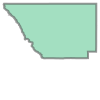

In [24]:
# Plot the shape of Larimer inline using the geometry method.
ctx.geometry



In [25]:
# Pick a Scene that has more than a sliver of data within our AOI.
scene = scenes[16]


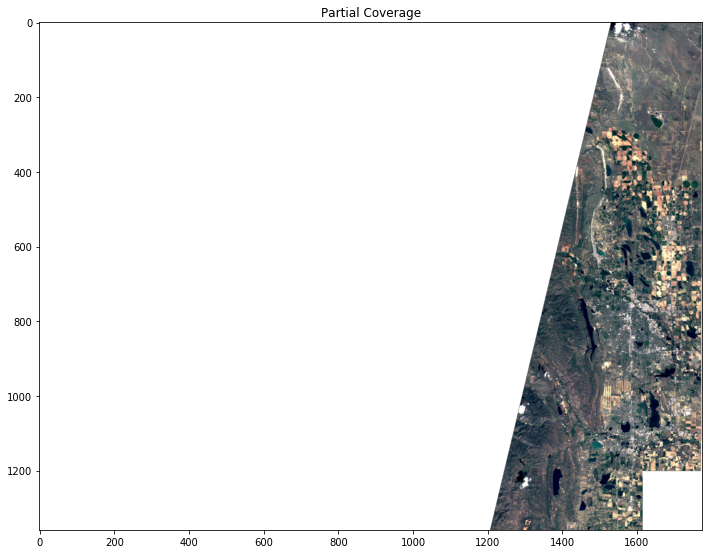

In [26]:
# A Scene or SceneCollection only contains the Metadata for the imagery
# We have to use another method to get the data back, in this case, the ndarray method
# Note that we are passing in the low resolution GeoContext
arr = scene.ndarray("red green blue", lowres_context)
dl.scenes.display(arr, title="Partial Coverage")


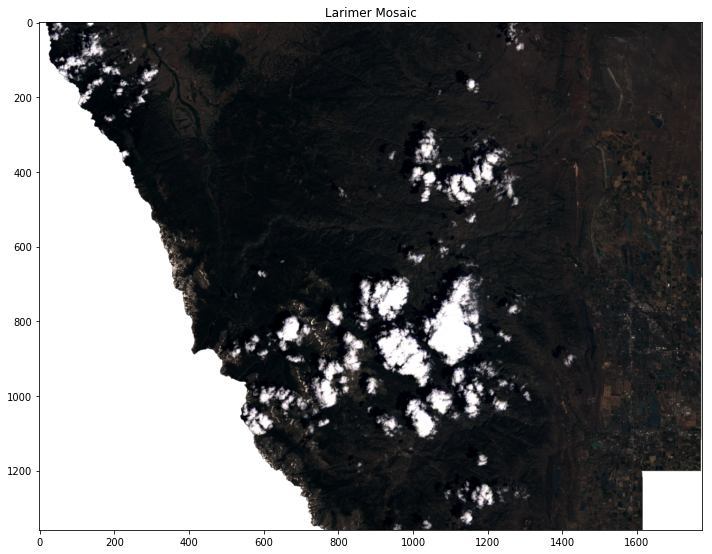

In [31]:
# Request a mosaic of data containing the red green and blue bands
mosaic = scenes.mosaic("red green blue", lowres_context)
dl.scenes.display(mosaic, title="Larimer Mosaic")


In [28]:
# Request a stack of data containing the red green and blue bands.
stack = scenes.stack("red green blue", lowres_context)

print("The stack method returns a {} containing the data for the same {} Scenes returned by the search method above.".format(type(stack),len(stack)))


The stack method returns a <class 'numpy.ma.core.MaskedArray'> containing the data for the same 75 Scenes returned by the search method above.


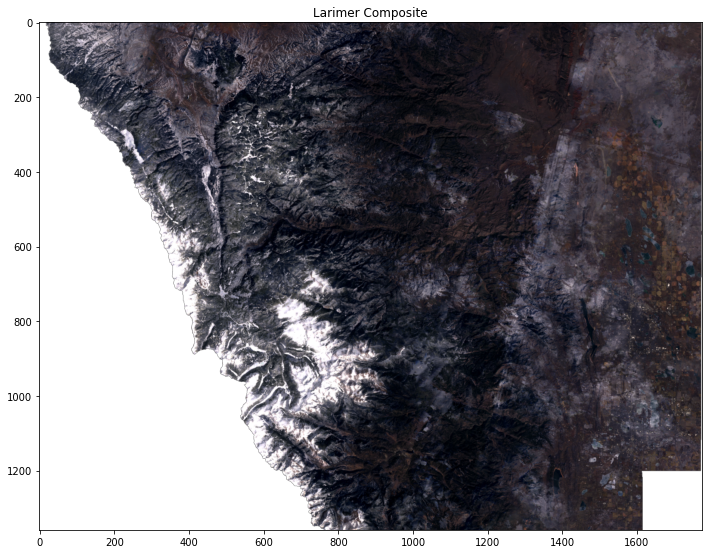

In [32]:
# We import the NumPy library so we can call the median method on our masked array to produce the final dataset
import numpy as np
composite = np.ma.median(stack, axis=0)
dl.scenes.display(composite, title="Larimer Composite")


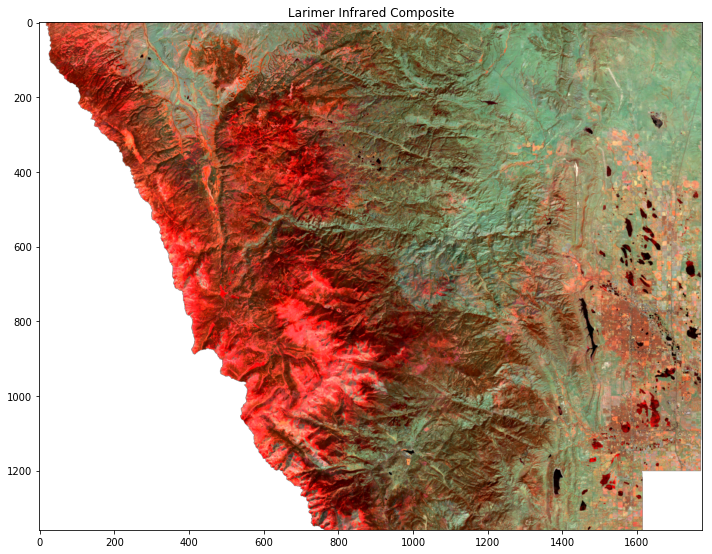

In [33]:
#Of course, you can work with any number of bands available for analysis and visualization.
#To complete the tutorial, let’s use the same process to display a false color image.
#Areas that appear red indicate healthy vegetation.
false_color_stack = scenes.stack("nir swir1 swir2", lowres_context)
composite = np.ma.median(false_color_stack, axis=0)
dl.scenes.display(composite, title="Larimer Infrared Composite")
